In [20]:
%pylab inline
import datetime

import os, sys
sys.path.append('/var/www/posada/api/handlers')

from multiprocessing import cpu_count
import re
import epr

from scipy.interpolate import RectBivariateSpline
from numpy import linspace, arange, row_stack, delete
from math import atan

sys.path.append('/home/mag/Documents/repos/solab/PySOL/')

# from cmod.createMapsEtopo1 import findSubsetIndices
from createMapsEtopo1 import findSubsetIndices
import pygrib

import pyresample as pr
from pyproj import Proj
# from cmod import distancelib
# from cmod import gshhs_rasterize
import distancelib
import gshhs_rasterize

from pylab import *

# import simplekml

# import ConfigParser
# import redis

numProcs = 4

def swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc', lonlim=(-180,180), latlim=(-90,90), ellps="WGS84", res=111.2e3, lat_ts=None, lat_0=None, lon_0=None):
    """
    Convert given swath coordinates to pyresample area definition.
    The arguments are standard for Proj:
    name
    proj
    lonlim
    latlim
    ellipsoid
    resolution(meters)
    lat_ts (latitude of true scale)
    lat_0,lon_0 is central point
    EXAMPLE:

    epsg3426 is the default one
    for epsg3413:
    swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=111.2e3, lat_ts=70, lat_0=90, lon_0=-45)

    """

    up    = max(latlim)
    down  = min(latlim)
    left  = min(lonlim)
    right = max(lonlim)
    
    print 'up, down, left, right: ', up, down, left, right

    area_id = name.replace(" ", "_").lower()
    proj_id = area_id

    if proj == 'eqc':
        p = Proj(proj=proj, llcrnrlat=up, urcrnrlat=down, llcrnrlon=left, urcrnrlon=right, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+llcrnrlat=' + str(up) + ' ' + \
             '+urcrnrlat=' + str(down) + ' ' + \
             '+llcrnrlon=' + str(left) + ' ' + \
             '+urcrnrlon=' + str(right) + ' ' + \
             '+ellps=' + str(ellps)
    elif lat_ts!=None and lat_0!=None:
        # lat_ts is latitude of true scale.
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, lat_ts=lat_ts, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+lat_ts=' + str(lat_ts) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0!=None and lat_0!=None and lat_ts==None:
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0==None and lat_0==None and lat_ts==None:
        # lon_0,lat_0 is central point.
        lat_0 = (up + down) / 2
        lon_0 = (right + left) / 2
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)

    left_ex1, up_ex1 = p(left, up)
    right_ex1, up_ex2 = p(right, up)
    left_ex2, down_ex1 = p(left, down)
    right_ex2, down_ex2 = p(right, down)
    lon = (left+right)/2.0
    if (lon >=0 and lon <90) or (lon >=-360 and lon < -270):
        print 11111111111
        area_extent = (
                       min(left_ex1, left_ex2, right_ex1, right_ex2),
                       min(down_ex1, down_ex2, up_ex1, up_ex2),
                       max(left_ex1, left_ex2, right_ex1, right_ex2),
                       max(down_ex1, down_ex2, up_ex1, up_ex2)
                      )
    elif (lon >=90 and lon <180) or (lon >=-270 and lon < -180):
        print 2222222222222
        area_extent = (
#                        min(left_ex1, left_ex2, right_ex1, right_ex2),
#                        min(down_ex1, down_ex2, up_ex1, up_ex2),
#                        max(left_ex1, left_ex2, right_ex1, right_ex2),
#                        max(down_ex1, down_ex2, up_ex1, up_ex2)
                       max(left_ex1, left_ex2, right_ex1, right_ex2),
                       max(down_ex1, down_ex2, up_ex1, up_ex2),
                       min(left_ex1, left_ex2, right_ex1, right_ex2),
                       min(down_ex1, down_ex2, up_ex1, up_ex2)
                       )
    elif (lon >= 180 and lon < 270) or (lon >= -180 and lon < -90):
        print 333333333333
        area_extent = (
                       min(left_ex1, left_ex2, right_ex1, right_ex2),
                       min(down_ex1, down_ex2, up_ex1, up_ex2),
                       max(left_ex1, left_ex2, right_ex1, right_ex2),
                       max(down_ex1, down_ex2, up_ex1, up_ex2)
#                        min(left_ex1, left_ex2),
#                        min(up_ex1, up_ex2),
#                        max(right_ex1, right_ex2),
#                        max(down_ex1, down_ex2)
                      )
    else:
        print 44444444444444444
        area_extent = (
                       min(left_ex1, left_ex2, right_ex1, right_ex2),
                       min(down_ex1, down_ex2, up_ex1, up_ex2),
                       max(left_ex1, left_ex2, right_ex1, right_ex2),
                       max(down_ex1, down_ex2, up_ex1, up_ex2)
                      )
    
    print 'left: ', left_ex1, left_ex2
    print 'right: ', right_ex1, right_ex2
    print 'up: ', up_ex1, up_ex2
    print 'down: ', down_ex1, down_ex2

#     Using abs() to avoid negative numbers of coloumns/rows as for epsg3413 for example
    xsize = abs(int((area_extent[2] - area_extent[0]) / res))
    ysize = abs(int((area_extent[3] - area_extent[1]) / res))
    
    swath_area_def = pr.utils.get_area_def(area_id, name, proj_id, proj4_args, xsize, ysize, area_extent)

#     print swath_area_def

    return swath_area_def

def imresize(image, size):
    """
    Resizes coefficient arrays using bivariate spline approximation.
    """
    m, n = image.shape
    X = linspace(0, m - 1, size[0])
    Y = linspace(0, n - 1, size[1])
    kx, ky = min([m - 1, 3]), min([n - 1, 3])
    interp = RectBivariateSpline(
        arange(m), arange(n), image, kx=kx, ky=ky)
    resized = interp(X, Y)
    return resized

def create_asar_image(iPath, oPaths, fileName):
    oPath_4326, oPath_3413 = oPaths
    
#     print '===============>s ', oPaths

    try:
        product = epr.Product(os.path.join(iPath, fileName))

        band = product.get_band('proc_data')
    except:
        return

    sc_w = product.get_scene_width()
    sc_h = product.get_scene_height()

    # if sc_w*sc_h > 33333333:
    #     print "ASAR Image too large, skipping"
    #     return False

    raw_counts = band.read_as_array(sc_w, sc_h)#, xstep=4, ystep=4)#, xoffset=100, yoffset=6500, xstep=2, ystep=2)

    incident_angle = product.get_band('incident_angle').read_as_array(sc_w, sc_h)#, xstep=4, ystep=4)

    # Get lat/lon from geolocation grid
    dataset = product.get_dataset('GEOLOCATION_GRID_ADS')
    fltp_lats = map(lambda x: \
                   dataset.read_record(x).get_field('first_line_tie_points.lats').get_elems(), \
                   range(dataset.get_num_records()))
    lltp_lats = map(lambda x: \
                   dataset.read_record(x).get_field('last_line_tie_points.lats').get_elems(), \
                   range(dataset.get_num_records()))
    fltp_lons = map(lambda x: \
                   dataset.read_record(x).get_field('first_line_tie_points.longs').get_elems(), \
                   range(dataset.get_num_records()))
    lltp_lons = map(lambda x: \
                   dataset.read_record(x).get_field('last_line_tie_points.longs').get_elems(), \
                   range(dataset.get_num_records()))

    fltp_lats = asarray(double(fltp_lats))/1e6
    lltp_lats = asarray(double(lltp_lats))/1e6
    fltp_lons = asarray(double(fltp_lons))/1e6
    lltp_lons = asarray(double(lltp_lons))/1e6

    lats = row_stack((fltp_lats, lltp_lats[-1,:]))
    lons = row_stack((fltp_lons, lltp_lons[-1,:]))

    lats = fliplr(lats)
    lons = fliplr(lons)
    
    if lats.max() <= 35:
        print "skipping no area overlap"
        return False
    print '=> ', fileName
    
#     area_def = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
#                                       lonlim=(lons.min(),lons.max()),
#                                       latlim=(lats.min(),lats.max()),
#                                       ellps="WGS84", res=1000, lat_ts=70, lat_0=90, lon_0=-45)
    
#     return

    lats_2 = imresize(lats, raw_counts.shape)
    lons_2 = imresize(lons, raw_counts.shape)

    # Trimming the array by removing zero values from rows and cols
    msk = []
    for m in range(raw_counts.shape[0]):
        if raw_counts[m,:].sum() == 0:
            msk.append(m)
    raw_counts = delete(raw_counts, msk, axis=0)
    lats_2 = delete(lats_2, msk, axis=0)
    lons_2 = delete(lons_2, msk, axis=0)
    incident_angle = delete(incident_angle, msk, axis=0)

    msk = []
    for n in range(raw_counts.shape[1]):
        if raw_counts[:,n].sum() == 0:
            msk.append(n)
    raw_counts = delete(raw_counts, msk, axis=1)
    lats_2 = delete(lats_2, msk, axis=1)
    lons_2 = delete(lons_2, msk, axis=1)
    incident_angle = delete(incident_angle, msk, axis=1)


    ## Adding Sigma_0
    calibration_constant = \
    product.get_dataset('MAIN_PROCESSING_PARAMS_ADS').read_record(0).get_field('calibration_factors.1.ext_cal_fact').get_elems()
    # sigma0 = 10*log10( raw_counts**2*sin(incident_angle*pi/180)/calibration_constant )
    sigma0 = raw_counts**2*sin(incident_angle*pi/180)/calibration_constant

    from scipy.signal import wiener
    sigma0w = wiener(sigma0, mysize=(7,7), noise=None)
    # sigma0w = sigma0

    ## Nice Image (roughness)
    pol = product.get_sph().get_field('MDS1_TX_RX_POLAR').get_elem()
    if pol == 'H/H':
        ph = (2.20495, -14.3561e-2, 11.28e-4)
        sigma0_hh_ref = exp( ( ph[0]+incident_angle*ph[1]+incident_angle**2*ph[2])*log(10) )
        roughness = sigma0w/sigma0_hh_ref
    elif pol == 'V/V':
        pv = (2.29373, -15.393e-2, 15.1762e-4)
        sigma0_vv_ref = exp( ( pv[0]+incident_angle*pv[1]+incident_angle**2*pv[2])*log(10) )
        roughness = sigma0w/sigma0_vv_ref

    ## Adding Model wind

    startTime = datetime.datetime.strptime(fileName[14:29],"%Y%m%d_%H%M%S")
#    ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)


    ## Reprojecting data

    # Pixel resolution
    # we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
#    pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
#                                                        ncepGFSmodelWind['lons_wind'], \
#                                                        ncepGFSmodelWind['lats_wind'].shape, 'km'))
    pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3
    # Note pxlResWind is in KM, multiply by 1e3 for meters
#    print "ASAR cell resolution, %s m"  % pxlResSAR
#    print "Wind cell resolution, %s km" % pxlResWind

    # reproject NCEP onto ASAR grid before calculations
    # Try both BivariateSpline, griddata and pyresample

#    ncep_def  = pr.geometry.GridDefinition (lons=ncepGFSmodelWind['lons_wind'], \
#                                            lats=ncepGFSmodelWind['lats_wind'])
    swath_def = pr.geometry.SwathDefinition(lons=lons_2, lats=lats_2)

    # wind_speed_model_swath = pr.kd_tree.resample_gauss(ncep_def, ncepGFSmodelWind['wind_speed'].ravel(), swath_def, \
    #                                              radius_of_influence=2*pxlResWind.max()*1e3, neighbours=12, \
    #                                              sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs)
#    wind_dir_model_swath   = pr.kd_tree.resample_gauss(ncep_def, ncepGFSmodelWind['wind_dir'].ravel(), swath_def, \
#                                                 radius_of_influence=2*pxlResWind.max()*1e3, neighbours=12, \
#                                                 sigmas=pxlResWind.max()*1e3, fill_value=None, nprocs=numProcs)

    # calculate bearing from initial lats/lons for further wind calculation
    bearing = zeros((lons.shape[0]-1,lons.shape[1]))

    for n in range(0,lons.shape[1]):
        col = ([lats[:-1,n], lons[:-1,n]], [lats[1:,n], lons[1:,n]])
        for m in range(0,lons.shape[0]-1):
            bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

    # interpolate to raw_counts.shape
    bearing_2 = imresize(bearing, raw_counts.shape)

    #NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
#    wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
#    try:
#        from cmod.cmod_gpu import rcs2windOpenCl
#        wind_speed_asar = rcs2windOpenCl(sar=sigma0w, windir=wind_dir_model_swath_rel, theta=incident_angle)
#    except Exception:
#        from cmod.cmod_vect import rcs2windPar
#        wind_speed_asar = rcs2windPar(sigma0w, cmdv=5, windir=wind_dir_model_swath_rel, theta=incident_angle, nprocs=numProcs)

#     for proj in ['EPSG:4326', 'EPSG:3413']:
    for proj in ['EPSG:3413']:
        print "    start projection %s" % proj
        if proj == 'EPSG:4326':
            oPath = oPath_4326
            area_def = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                                      lonlim=(lons_2.min(),lons_2.max()),
                                      latlim=(lats_2.min(),lats_2.max()),
                                      ellps="WGS84", res=pxlResSAR.max())
            # Set the parameters for GSHHS masking
            proj_ = '4326'
            proj_name=None
            units = 'deg'
        elif proj == 'EPSG:3413':
            oPath = oPath_3413
            area_def = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                                      lonlim=(lons_2.min(),lons_2.max()),
                                      latlim=(lats_2.min(),lats_2.max()),
                                      ellps="WGS84", res=pxlResSAR.max(), lat_ts=70, lat_0=90, lon_0=-45)
            # Set the parameters for GSHHS masking
            proj_ = '+units=m +ellps=WGS84 +lon_0=-45 +proj=stere +lat_ts=70 +lat_0=90'
            proj_name = '3413'
            units = 'm'

        print area_def
        return swath_def, roughness, area_def, pxlResSAR, numProcs, lons_2, lats_2

        roughness_res = pr.kd_tree.resample_nearest(swath_def, roughness.ravel(), area_def,
                                                    radius_of_influence=4*pxlResSAR.max(),
                                                    epsilon=0.5, nprocs=numProcs, fill_value=None)
#        wind_speed_asar_res = pr.kd_tree.resample_nearest(swath_def, wind_speed_asar.ravel(), area_def,
#                                                          radius_of_influence=4*pxlResSAR.max(),
#                                                          epsilon=0.5, nprocs=numProcs, fill_value=None)

        # Apply Mask from GSHHS
        # ESRI shapefile containing land polygons
#        shapefile = '/nfs/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'
#        lonlim=(lons_2.min(),lons_2.max())
#        latlim=(lats_2.min(),lats_2.max())
#        lakes = True

#        mask_arr = gshhs_rasterize.gshhs_rasterize(lonlim, latlim, units, roughness_res.shape,
#                                                   proj_, proj_name, lakes, shapefile)
#        roughness_masked = ma.masked_where(mask_arr, roughness_res)
        roughness_masked = roughness_res
#        wind_speed_asar_masked = ma.masked_where(mask_arr, wind_speed_asar_res)
        print '===============> ', oPath

        oFileName = os.path.join(oPath[0], fileName+'.png')
        gray()
        imsave(oFileName, roughness_masked, vmin=0, vmax=2)

#        oFileNameWind = os.path.join(oPath[1], fileName+'.png')
#        jet()
#        imsave(oFileNameWind, wind_speed_asar_masked, vmin=0, vmax=20)

#        for _path in oPath:
#            create_KML_asar(area_def.area_extent, os.path.join(_path, fileName+'.kml'))
    product.close()
    return roughness_masked
    return True

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [110]:
import os
iPath = '/media/SOLabNFS2/store/satellite/asar/2008/094'
oPaths = ['/tmp', '/tmp']

# fileName = 'ASA_IMM_1PNPDE20080403_030720_000000662067_00233_31850_9175.N1'
fileName = 'ASA_WSM_1PNPDK20080403_150720_000000552067_00240_31857_3007.N1'


swath_def, roughness, area_def, pxlResSAR, numProcs, lons_2, lats_2 = create_asar_image(iPath, oPaths, fileName)



=>  ASA_WSM_1PNPDK20080403_150720_000000552067_00240_31857_3007.N1
    start projection EPSG:3413
up, down, left, right:  87.1246386333 83.1277929088 -18.8219129711 40.0229268787
11111111111
left:  137441.111543 328800.942287
right:  310368.263439 742495.286373
up:  -279587.093968 -27028.5646199
down:  -668857.366734 -64660.5474583
Area ID: temporal_swath_epsg_projection_3413
Name: Temporal SWATH EPSG Projection 3413
Projection ID: temporal_swath_epsg_projection_3413
Projection: {'ellps': 'WGS84', 'lat_0': '90', 'lat_ts': '70', 'lon_0': '-45', 'proj': 'stere'}
Number of columns: 8121
Number of rows: 8615
Area extent: (137441.1115433003, -668857.3667342473, 742495.2863726339, -27028.56461986439)


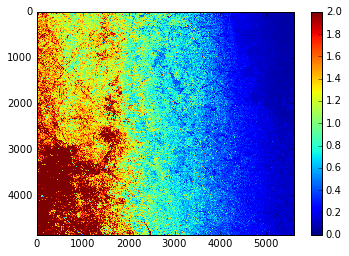

In [111]:
imshow(roughness, vmin=0, vmax=2)
colorbar()

In [112]:
area_def = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                          lonlim=(lons_2.min(),lons_2.max()),
                          latlim=(lats_2.min(),lats_2.max()),
                          ellps="WGS84", res=pxlResSAR.max(), lat_ts=70, lat_0=90, lon_0=-45)
roughness_res = pr.kd_tree.resample_nearest(swath_def, roughness.ravel(), area_def,
                                            radius_of_influence=4*pxlResSAR.max(),
                                            epsilon=0.5, nprocs=numProcs, fill_value=None)

up, down, left, right:  87.1246386333 83.1277929088 -18.8219129711 40.0229268787
11111111111
left:  137441.111543 328800.942287
right:  310368.263439 742495.286373
up:  -279587.093968 -27028.5646199
down:  -668857.366734 -64660.5474583


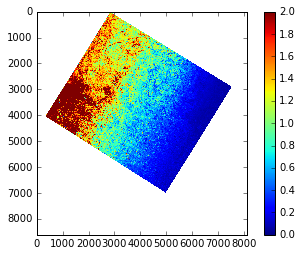

In [113]:
imshow(roughness_res, vmin=0, vmax=2)
colorbar()

In [114]:
roughness.shape
roughness_part = []
roughness_part.append(roughness[:3000])
roughness_part.append(roughness[3000:])

In [115]:
lats_part = []
lats_part.append(lats_2[:3000])
lats_part.append(lats_2[3000:])
lons_part = []
lons_part.append(lons_2[:3000])
lons_part.append(lons_2[3000:])

swath_def_part = []
swath_def_part.append(pr.geometry.SwathDefinition(lons=lons_part[0], lats=lats_part[0]))
swath_def_part.append(pr.geometry.SwathDefinition(lons=lons_part[1], lats=lats_part[1]))

In [116]:
area_def_part = []
for i in range(2):
    area_def_part.append(swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere',
                                        lonlim=(lons_part[i].min(),lons_part[i].max()),
                                        latlim=(lats_part[i].min(),lats_part[i].max()),
                                        ellps="WGS84", res=pxlResSAR.max(), lat_ts=70, lat_0=90, lon_0=-45))

up, down, left, right:  87.1246386333 83.2051071237 2.36953809311 40.0229268787
11111111111
left:  229213.702397 542165.836967
right:  310368.263439 734123.080582
up:  -210997.822001 -27028.5646199
down:  -499079.285256 -63931.4500219
up, down, left, right:  87.0742763736 83.1277929088 -18.8219129711 8.31529559562
44444444444444444
left:  139849.40276 328800.942287
right:  254214.970272 597686.655211
up:  -284486.116794 -189380.450391
down:  -668857.366734 -445253.746605


In [117]:
roughness_res_part = []
for i in range(2):
    print swath_def_part[i].shape, roughness_part[i].shape, area_def_part[i].shape
    roughness_res_part.append(pr.kd_tree.resample_nearest(swath_def_part[i], roughness_part[i].ravel(), area_def_part[i],
                                                      radius_of_influence=4*pxlResSAR.max(),
                                                      epsilon=0.5, nprocs=numProcs, fill_value=None))

(3000, 5601) (3000, 5601) (6336, 6777)
(1860, 5601) (1860, 5601) (6436, 6145)


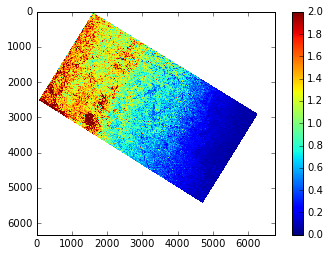

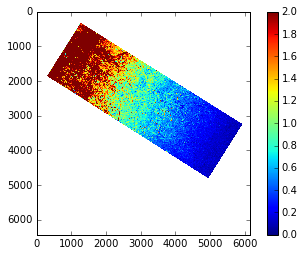

In [118]:
for i in range(2):
    imshow(roughness_res_part[i], vmin=0, vmax=2)
    colorbar()
    show()

In [119]:
def clip_masked(masked_array):
    si, se = np.where(~masked_array.mask)
    return masked_array[si.min():si.max() + 1, se.min():se.max() + 1]

In [120]:
part0 = roughness_res_part[0]
part1 = roughness_res_part[1]

In [121]:
clip_part0 = clip_masked(part0)
clip_part1 = clip_masked(part1)

mask_ind1_left = np.where(~clip_part1[:,0].mask)[0]
# print clip_part1.shape[0] - mask_ind1_left.max()
print mask_ind1_left.max()

mask_ind1_right = np.where(~clip_part1[:,-1].mask)[0]
# print clip_part1.shape[0] - mask_ind1_right.max()
print mask_ind1_right.max()

result_1_index = max(mask_ind1_left.max(), mask_ind1_right.max())
print 'top array index:', result_1_index
print 'top array indent:', clip_part1.shape[0] - result_1_index

mask_ind0_left = np.where(~clip_part0[:,0].mask)[0]
print mask_ind0_left.min()

mask_ind0_right = np.where(~clip_part0[:,-1].mask)[0]
print mask_ind0_right.min()
# imshow(clip_part0, vmin=0, vmax=2)

1530
2912
top array index: 2912
top array indent: 1555
2477
2868


(4467, 5613)


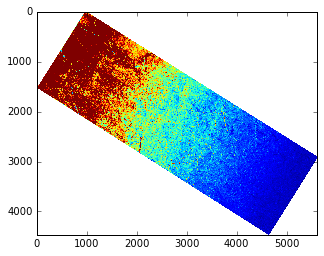

(5390, 6210)


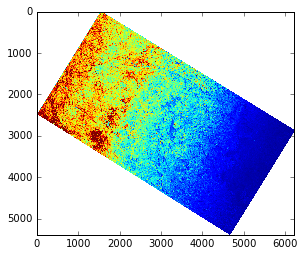

In [122]:
print clip_part1.shape
imshow(clip_part1, vmin=0, vmax=2)
show()
print clip_part0.shape
imshow(clip_part0, vmin=0, vmax=2)
show()

In [127]:
import dask.array as da
daskarray = da.from_array(roughness, chunks=(1000, 1000))

In [128]:
daskresult = daskarray.mean()
daskresult._visualize()

TypeError: unhashable type: 'numpy.ndarray'